In [12]:
NUM_OBJ = 6
NUM_VAR = 18
bounds = [(0.0, 1.0)]*NUM_VAR
NUM_GEN = 20
POP_SIZE = 60

# Imprime Gráficos

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_parallel(pareto_front):
    """
    Plota gráfico de coordenadas paralelas para soluções com n objetivos.

    :param pareto_front: Lista ou array de pontos da fronteira de Pareto (n_soluções × n_objetivos).
    """
    # Normalizar os valores dos objetivos para [0, 1]
    def normalize(solutions: np.ndarray) -> np.ndarray:
        return (solutions - solutions.min(axis=0)) / (solutions.max(axis=0) - solutions.min(axis=0))

    pareto_front = np.array(pareto_front, dtype=float)
    normalized_solutions = normalize(pareto_front)

    # Criar figura
    plt.figure(figsize=(10, 6))

    # Plotar cada solução como uma linha
    for sol in normalized_solutions:
        plt.plot(np.arange(normalized_solutions.shape[1]), sol, marker='o', alpha=0.7)

    # Configurações dos eixos
    plt.xticks(np.arange(normalized_solutions.shape[1]), [f"Objetivo {i+1}" for i in range(normalized_solutions.shape[1])])
    plt.xlabel("Objetivos")
    plt.ylabel("Valores Normalizados")
    plt.title("Gráfico de Coordenadas Paralelas - Soluções Normalizadas")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_3d(pareto_front: np.ndarray) -> None:
    """
    Plota uma frente de Pareto em 3D (para M=3).
    
    :param pareto_front: np.ndarray de shape (N,3)
    """
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    pareto_front = np.asarray(pareto_front)
    assert pareto_front.shape[1] == 3, "A fronteira deve ter 3 objetivos"

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        pareto_front[:, 0],
        pareto_front[:, 1],
        pareto_front[:, 2],
        s=8, alpha=0.7, c="tab:blue"
    )

    ax.set_title("DTLZ2 Pareto Front (M=3) — First Octant of Unit Sphere")
    ax.set_xlabel("$f_1$")
    ax.set_ylabel("$f_2$")
    ax.set_zlabel("$f_3$")
    plt.tight_layout()
    plt.show()

# DTLZ2

In [14]:
import numpy as np

def dtlz2(x: np.ndarray, M: int = NUM_OBJ) -> np.ndarray:
    """
    DTLZ2 (minimização). x: (n,), n = M-1 + k, tipicamente k=10 -> n=15 p/ M=6.
    Retorna vetor de M objetivos.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    assert n >= M - 1, "DTLZ2: n deve ser >= M-1"

    k = n - (M - 1)
    g = np.sum((x[n - k:] - 0.5) ** 2)

    f = np.empty(M, dtype=float)
    for m in range(M):
        val = 1.0 + g
        for i in range(M - m - 1):
            val *= np.cos(0.5 * np.pi * x[i])
        if m > 0:
            val *= np.sin(0.5 * np.pi * x[M - m - 1])
        f[m] = val
    return f  

# Pontos de referência

In [15]:
import numpy as np

def generate_reference_points(M: int, p: int) -> np.ndarray:
    def generate_recursive(
        points: list[list[float]],
        num_objs: int,
        left: int,
        total: int,
        depth: int,
        current_point: list[float]
    ) -> None:
        if depth == num_objs - 1:
            current_point.append(left / total)
            points.append(current_point.copy())
            current_point.pop()
        else:
            for i in range(left + 1):
                current_point.append(i / total)
                generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                current_point.pop()

    points: list[list[float]] = []
    generate_recursive(points, M, p, p, 0, [])
    return np.array(points, dtype=float)

print(generate_reference_points(NUM_OBJ, 40))

# A função acima chega a consumir metade do tempo que a da pymoo
#from pymoo.util.ref_dirs import get_reference_directions
#print(get_reference_directions("das-dennis", n_dim=NUM_OBJ, n_partitions=40))

[[0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.025 0.975]
 [0.    0.    0.    0.    0.05  0.95 ]
 ...
 [0.975 0.    0.025 0.    0.    0.   ]
 [0.975 0.025 0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.   ]]


# Libs e Operadores

In [16]:
import sys
import os

# Adiciona o diretório base ao sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Ajuste conforme a localização do notebook
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from modules.nsga2 import nsga2_func
from modules.nsga3 import nsga3_func
from modules.nsga3_deap import nsga3_deap_func
from modules.nsga3_pymoo import nsga3_pymoo_func


In [17]:
import random
import numpy as np

Vector = np.ndarray
Bounds = list[tuple[float, float]]

# Hiperparâmetros (ajuste se quiser, mantendo as assinaturas)
_ETA_C = 20.0   # distribution index do SBX (tipicamente 10–30)
_ETA_M = 25.0   # distribution index da mutation (tipicamente 10–50)
_MUTATION_RATE = 0.5  # prob. de mutar o indivíduo (mantida a lógica original)

def crossover(parent1: Vector, parent2: Vector) -> tuple[Vector, Vector]:
    """
    SBX (Deb & Agrawal, 1995). Opera componente a componente.
    """
    n = parent1.shape[0]
    c1 = np.empty_like(parent1)
    c2 = np.empty_like(parent2)

    for i in range(n):
        x1 = parent1[i]
        x2 = parent2[i]

        if random.random() < 0.5 and abs(x1 - x2) > 1e-14:
            if x1 > x2:
                x1, x2 = x2, x1  # garantir x1 <= x2

            u = random.random()
            beta = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1 + 1e-14))  # limites desconhecidos aqui; não usados
            # Fórmula padrão sem limites explícitos:
            if u <= 0.5:
                beta_q = (2.0 * u) ** (1.0 / (_ETA_C + 1.0))
            else:
                beta_q = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (_ETA_C + 1.0))

            c1[i] = 0.5 * ((x1 + x2) - beta_q * (x2 - x1))
            c2[i] = 0.5 * ((x1 + x2) + beta_q * (x2 - x1))
        else:
            # sem recombinação (ou genes idênticos): copiar
            c1[i] = x1
            c2[i] = x2

    return (c1, c2)


def mutation(individual: Vector, bounds: Bounds) -> Vector:
    """
    Polynomial mutation (Deb, 2001). Aplica por gene com prob ~ 1/n.
    Mantém a mesma probabilidade global de mutação do código original (_MUTATION_RATE).
    """
    n = individual.shape[0]
    pm = 1.0 / n  # probabilidade por variável (prática comum)

    if random.random() < _MUTATION_RATE:
        y = individual.copy()
        for i in range(n):
            if random.random() < pm:
                yl, yu = bounds[i]
                if yu <= yl:  # proteção
                    continue
                y_i = y[i]
                # Normalizar para [0,1] dentro dos limites
                delta1 = (y_i - yl) / (yu - yl)
                delta2 = (yu - y_i) / (yu - yl)
                r = random.random()

                mut_pow = 1.0 / (_ETA_M + 1.0)
                if r < 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * r + (1.0 - 2.0 * r) * (xy ** (_ETA_M + 1.0))
                    deltaq = (val ** mut_pow) - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - r) + 2.0 * (r - 0.5) * (xy ** (_ETA_M + 1.0))
                    deltaq = 1.0 - (val ** mut_pow)

                y[i] = y_i + deltaq * (yu - yl)
                # Garantir limites
                y[i] = np.clip(y[i], yl, yu)
        return y

    return individual


# Métricas

In [18]:
import numpy as np

def hypervolume(
    pareto_front: list[tuple[float, ...]] | np.ndarray,
    reference_point: list[float] | np.ndarray | None = None,
    delta: float = 0.1
) -> float:
    """
    Hipervolume (minimização em todos os objetivos).
    Corrigido para ordenar por f1 decrescente e evitar larguras negativas.

    :param pareto_front: lista/array (n_soluções x M)
    :param reference_point: ponto de referência (pior que todos os pontos). Se None, usa max + delta.
    :param delta: margem para referência automática
    """
    pf = np.array(pareto_front, dtype=float)
    if pf.ndim != 2:
        raise ValueError("pareto_front deve ser 2D (n_soluções x M).")

    # referência automática
    if reference_point is None:
        ref = np.max(pf, axis=0) + float(delta)
    else:
        ref = np.array(reference_point, dtype=float)

    if ref.shape[0] != pf.shape[1]:
        raise ValueError("Dimensão do reference_point deve ser igual ao número de objetivos.")
    if np.any(pf > ref):
        raise ValueError("reference_point deve ser >= a todos os pontos do Pareto em cada objetivo (minimização).")

    # remove duplicatas (opcional)
    pf = np.unique(pf, axis=0)

    # Ordena por f1 DECRESCENTE (minimização) para garantir widths positivos: width = prev - f1_i
    order = np.argsort(-pf[:, 0])
    pf = pf[order]

    def hv_2d(points: np.ndarray, ref2d: np.ndarray) -> float:
        # points: (k, 2) ordenado por f1 DECRESCENTE
        hv, prev_f1 = 0.0, ref2d[0]
        for f1, f2 in points:
            width = prev_f1 - f1
            if width < 0:
                # se acontecer, é bug de ordenação -> saneia para zero
                width = 0.0
            height = ref2d[1] - f2
            if height < 0:
                # ponto de referência inválido
                raise ValueError("reference_point[1] menor que um f2; HV negativo não faz sentido em minimização.")
            hv += width * height
            prev_f1 = f1
        return hv

    def recursive_hv(points: np.ndarray, ref_nd: np.ndarray) -> float:
        m = points.shape[1]
        if m == 2:
            return hv_2d(points, ref_nd)
        # Ordenado por f1 DECRESCENTE; fatiamos o “slab” entre prev e p[0]
        volume, prev_f1 = 0.0, ref_nd[0]
        for i, p in enumerate(points):
            width = prev_f1 - p[0]
            if width < 0:
                width = 0.0
            # Subconjunto relevante para este slab: pontos com f1 <= prev_f1,
            # o que corresponde a points[i:] pois estamos em ordem decrescente.
            slice_points = points[i:, 1:]
            volume += width * recursive_hv(slice_points, ref_nd[1:])
            prev_f1 = p[0]
        return volume

    return recursive_hv(pf, ref)


In [19]:
import numpy as np

def count_points_around_refs(
    pareto_front: np.ndarray,
    n_obj: int,
    divisions: int,
    r: float
) -> tuple[int, int]:
    """
    Conta quantos pontos da fronteira estão a menos que r dos pontos de referência projetados
    na fronteira do DTLZ2 e quantos estão fora.

    :param pareto_front: np.ndarray de shape (N, M), pontos da fronteira aproximada
    :param n_obj: número de objetivos (M)
    :param divisions: número de divisões para gerar pontos de referência
    :param r: raio das bolinhas
    :return: (n_dentro, n_fora)
    """
    pareto_front = np.asarray(pareto_front, dtype=float)

    # 1. Gerar ref points
    ref_points = generate_reference_points(n_obj, divisions)

    # 2. Projetar na fronteira da hiperesfera (DTLZ2)
    proj_refs = ref_points / np.linalg.norm(ref_points, axis=1, keepdims=True)

    # 3. Para cada ponto da fronteira, calcular distância mínima até as refs
    n_dentro = 0
    for p in pareto_front:
        dist = np.linalg.norm(proj_refs - p, axis=1)
        if np.min(dist) <= r:
            n_dentro += 1

    n_fora = len(pareto_front) - n_dentro
    return n_dentro, n_fora


# Experimentos

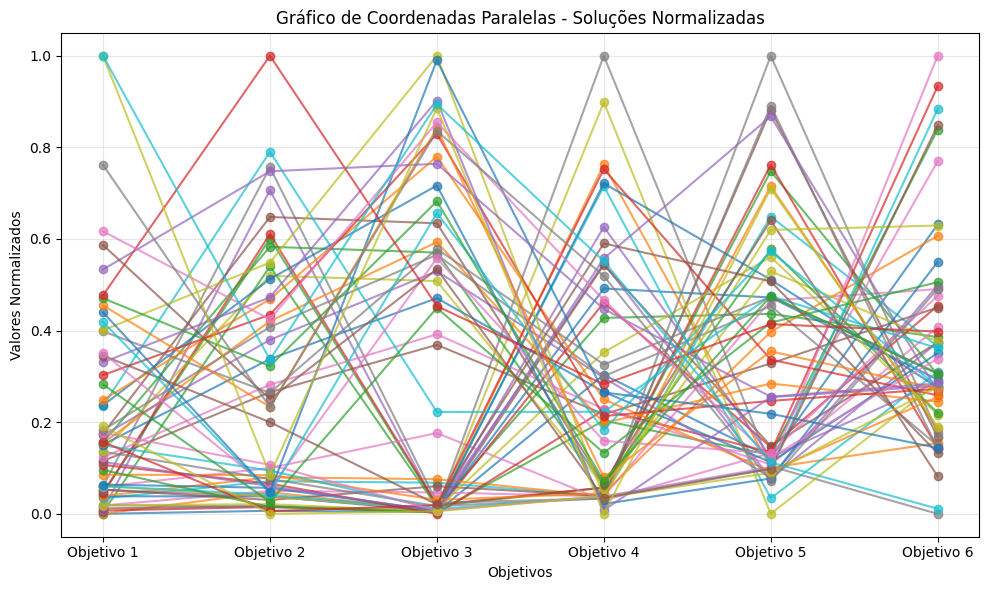

hv:7711.94841910139
(0, 60)
[(0.010328241480549021, 0.00046147347258830275, 0.003152736241079774, 0.8744558880055507, 0.13036270277880815, 1.8481743925644312), (0.010570669655401526, 0.016312482488943826, 0.01118573589629125, 2.370565854331049, 0.05559605350170548, 0.02838462754744939), (0.012840078378341738, 0.20899918648066645, 0.03247958072729026, 1.2787862078018322, 1.1809754562153227, 0.9108470228349421), (0.015989606617583082, 0.0036888796699398353, 0.005004105806129527, 1.3879593634747083, 0.20691510738454608, 1.170518370581663), (0.016834289673692427, 0.2740133465786513, 0.028889837765271046, 1.6659189540199169, -0.025170191184133474, 0.8676329242146568), (0.019702091995390372, 0.004545368022822921, 0.003191241375976658, 1.656094931223552, 0.21487335003340907, 0.8654954574851825), (0.024796318373631582, 0.01742885604007993, 0.1121156510508127, 0.00949966098792256, 1.2783706576618583, 1.3095853528566208), (0.02523219896897105, 0.004143935850106641, 0.015189219997511997, 3.143746

In [20]:
pareto_front = nsga3_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds, 
    dtlz2, 
    crossover, 
    mutation)

plot_parallel(pareto_front)

# Calcular o hipervolume
hv = hypervolume(pareto_front)

print(f"hv:{hv}")
print(count_points_around_refs(pareto_front, NUM_OBJ, 10, 0.15))
print(pareto_front)
if NUM_OBJ==3:
    plot_3d(pareto_front)

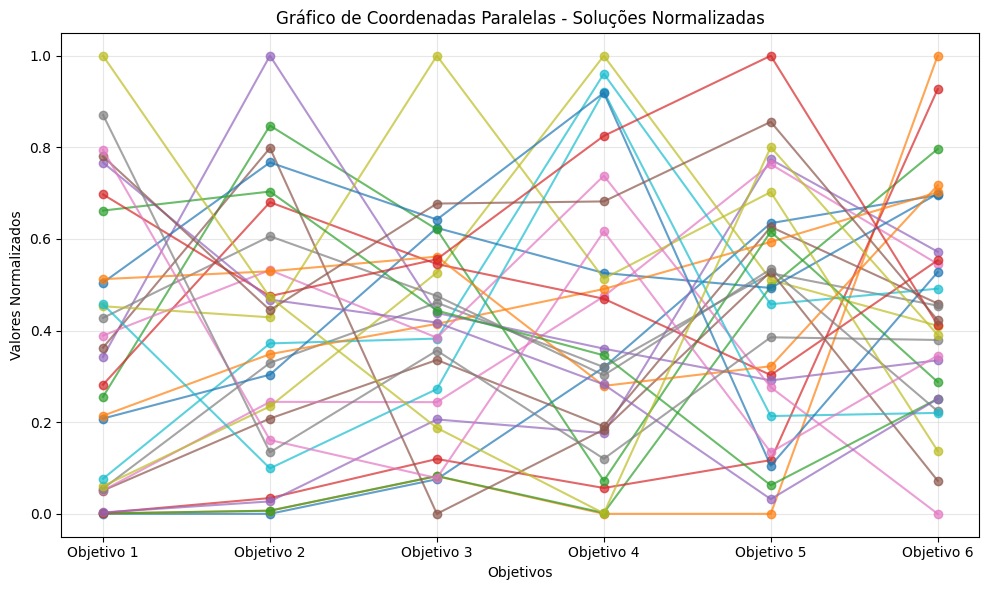

hv:51.58253654572068
(0, 29)
[(-0.0025223826538677643, -0.006008219273173751, -0.011150525494521557, 0.3047015618114896, 0.7586826177019008, 1.0707329174716478), (-3.4221156537875534e-05, -0.00015147382417166525, -0.0007306544745780276, -0.002250512720112608, -0.027657826184614594, 1.5071564274491316), (-2.8317422315702005e-06, -5.415486793499883e-06, -0.00012406932334737655, -0.000309134158772373, 0.5873935815145747, 1.2151485886856817), (0.0035707295468583714, 0.023966411486155147, 0.05831904817227396, 0.05187041800584978, 0.11755375812128067, 1.4027285402067724), (0.007386434959336432, 0.0175898458305635, 0.19390880876405675, 0.16677615231113832, 0.9311235116521748, 0.8937122515122853), (0.16312173210789532, 0.17511105559197315, 0.3981094188594024, 0.18098820232695398, 0.7486903349695959, 0.7314721859296353), (0.1638340352118924, 0.20683475108051483, 0.2532475608154321, 0.45334183788561583, 0.9182060825954251, 0.8551610151606384), (0.17678695856259682, 0.2809898829524523, 0.59451614

In [21]:
pareto_front = nsga3_deap_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds, 
    dtlz2, 
    crossover, 
    mutation)

plot_parallel(pareto_front)

# Calcular o hipervolume
hv = hypervolume(pareto_front)

print(f"hv:{hv}")
print(count_points_around_refs(pareto_front, NUM_OBJ, 10, 0.15))
print(pareto_front)
if NUM_OBJ==3:
    plot_3d(pareto_front)

This might cause unwanted behavior of the algorithm. 
Please make sure pop_size is equal or larger than the number of reference directions. 


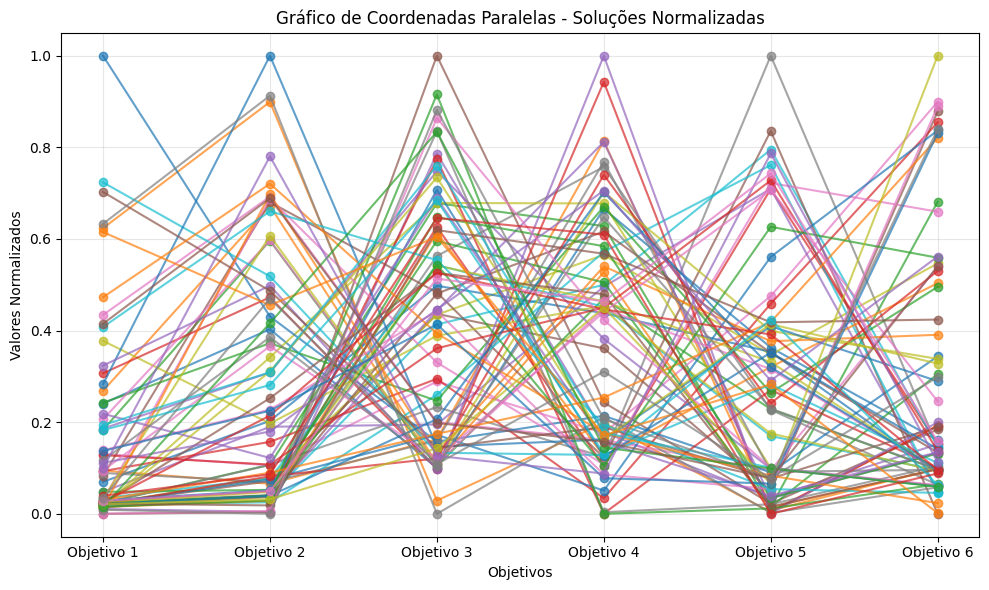

hv:11076.806993874987
(0, 78)
[(0.4207462861477997, 0.5566972542864396, -0.013273790551600433, 1.1134565812928285, 0.463013036112697, 0.1752313690564249), (0.13959961592806297, 0.03978880898578024, 0.11644044336668806, 1.3499860044838685, -0.1011632730258531, 0.07629552569767441), (0.0035485816944227644, 0.10346993220631502, 1.1786428133872964, 1.053231419364854, -0.10120702339400604, 0.9932488956292999), (0.01162500275063817, 0.014516995640284313, 1.072135557004095, 0.21574059722388467, 1.0231438662320866, 0.16260537638044362), (-0.021625555358669984, -0.054185880374034115, 1.4012765665588724, 0.33305483593916607, -0.06753463170068183, 0.1618592273727327), (0.0012889969652588712, 0.04836336666516849, 0.6807729458380836, 0.6262745738803032, -0.04339707127919167, 1.3029487210339599), (0.20968094636084025, 0.10127302346859691, 0.3764267122783903, 0.3305959605325863, 0.6449271423199301, 1.3359080246716684), (0.0023524749476900564, 0.10257616371451918, 0.2613537742375776, 0.247351144106395

In [22]:
pareto_front = nsga3_pymoo_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds, 
    dtlz2, 
    crossover, 
    mutation)

plot_parallel(pareto_front)

# Calcular o hipervolume
hv = hypervolume(pareto_front)

print(f"hv:{hv}")
print(count_points_around_refs(pareto_front, NUM_OBJ, 10, 0.15))
print(pareto_front)
if NUM_OBJ==3:
    plot_3d(pareto_front)